In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd

# CSV 불러오기
data = pd.read_csv("/content/drive/MyDrive/25-1/공모전/직업_추가.csv")

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9829 entries, 0 to 9828
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   post_id    9829 non-null   int64  
 1   제목         9777 non-null   object 
 2   내용         9825 non-null   object 
 3   작성일        9809 non-null   object 
 4   해시태그       3226 non-null   object 
 5   이직_원인_후보   9829 non-null   object 
 6   TFIDF_키워드  9829 non-null   object 
 7   이직확률       9829 non-null   float64
 8   tag        9829 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 691.2+ KB


In [24]:
data.head()

,post_id,제목,내용,작성일,해시태그,이직_원인_후보,TFIDF_키워드,이직확률,tag
0,1,"중반/NNG,전공자/NNG,섬유/NNG,업계/NNG,취업/NNG","안녕하세요/NNP,중반/NNG,남자/NNG,육아/NNG,경력/NNG,단절/NNG,기...",NaN,NaN,"['경력', '직무', '나이', '문제', '전공']","['섬유', '업계', '지식', '무역', '실무']",0.582,섬유·의류·패션
1,2,"경력/NNG,경력/NNG,기술/NNG,기입/NNG","공간/NNG,디자인/NNG,분야/NNG,패키지/NNG,디자인/NNG,이직/NNG,준...",NaN,패키지디자인,"['경험', '디자인', '분야', '디자이너', '취준생']","['공간', '디자인', '녹이', '구현', '패키지']",0.246,디자인·CAD
2,3,"온라인/NNG,토스/NNG,기획/NNG,스터디/NNG,모집/NNG,현직/NNG,취준...","혼자/MAG,스터디/NNG,함께/MAG,현직/NNG,인사이트/NNP,교류/NNG,스...",NaN,NaN,"['지원', '배우', '혼자', '기획', '성장']","['스터디', '인사이트', '기획자', '제공', '현직']",0.395,사무·경영지원
3,4,"실내/NNG,디자인/NNG,분야/NNG,순위/NNG,매기/VV","상가/NNG,경력/NNG,현재/MAG,학교/NNG,위주/NNG,인테리어/NNG,회사...",NaN,NaN,"['경력', '디자인', '분야', '학교', '선택']","['주거', '상가', '인테리어', '감명', '학교']",0.564,디자인·CAD
4,5,"물류/NNG,아웃소싱/NNG,소속/NNG,이직/NNG,가능/NNG","기업/NNG,규모/NNG,물류/NNG,사업/NNG,복지/NNG,인건비/NNG,관리/...",NaN,NaN,"['기업', '관리', '규모', '중견', '사용']","['아웃소싱', '원청', '복지', '본사', '물류']",0.446,물류관리자·기타


1. 이직확률 기반으로 구간 나누기
- 이직확률의 의미 손실 x

2. 각 tag별 클러스터링 진행

In [25]:
data['tag'].value_counts()

,count
tag,
디자인·CAD,1132
회계담당자·기타,938
솔루션·SI·CRM·ERP,878
광고·홍보·전시,709
사무·경영지원,665
SW,581
백화점·유통·도소매,495
생산·제조,457
음식료·외식·프랜차이즈,380


In [27]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
import ast

# 데이터 준비
df = data

# 결과 저장용
df_all = []
silhouette_summary = []

# 텍스트 전처리
def join_keywords(row):
    try:
        tfidf_kw = " ".join(ast.literal_eval(row['TFIDF_키워드']))
        cause_kw = " ".join(ast.literal_eval(row['이직_원인_후보']))
    except:
        tfidf_kw = cause_kw = ""
    return tfidf_kw + " " + cause_kw

# 최적 k 계산
def get_best_k(X, k_range=range(2, 9)):
    best_k = 2
    best_score = -1
    for k in k_range:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            labels = kmeans.fit_predict(X)
            score = silhouette_score(X, labels)
            if score > best_score:
                best_k, best_score = k, score
        except:
            continue
    return best_k, best_score

# 그룹별 클러스터링
def process_tag_group(df_tag, tag_name):
    df_tag = df_tag.copy()
    df_tag["텍스트_입력"] = df_tag.apply(join_keywords, axis=1)

    tfidf = TfidfVectorizer()
    X_text = tfidf.fit_transform(df_tag["텍스트_입력"])

    scaler = MinMaxScaler()
    X_prob = scaler.fit_transform(df_tag[["이직확률"]])
    X_combined = hstack([X_text, X_prob])

    if len(df_tag) < 10:
        df_tag["cluster"] = -1
        silhouette_summary.append({
            "tag": tag_name,
            "n_rows": len(df_tag),
            "n_clusters": 0,
            "silhouette_score": None
        })
    elif len(df_tag) < 30:
        kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_combined)
        score = silhouette_score(X_combined, labels)
        df_tag["cluster"] = labels
        silhouette_summary.append({
            "tag": tag_name,
            "n_rows": len(df_tag),
            "n_clusters": 2,
            "silhouette_score": score
        })
    else:
        best_k, score = get_best_k(X_combined)
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
        df_tag["cluster"] = kmeans.fit_predict(X_combined)
        silhouette_summary.append({
            "tag": tag_name,
            "n_rows": len(df_tag),
            "n_clusters": best_k,
            "silhouette_score": score
        })

    return df_tag

# 전체 tag 그룹에 대해 실행
for tag_name, group in df.groupby("tag"):
    clustered_df = process_tag_group(group, tag_name)
    df_all.append(clustered_df)

# 결과 통합
result_df = pd.concat(df_all).reset_index(drop=True)

# 요약 데이터프레임 생성
summary_df = pd.DataFrame(silhouette_summary)


In [28]:
summary_df.head(200)

,tag,n_rows,n_clusters,silhouette_score
0,SW,581,2,0.056109
1,건설·시공·토목·조경,141,2,0.069246
2,건축·설비·환경,272,2,0.061674
3,경리·기타,32,2,0.055771
4,공기업·공공기관,24,2,0.006329
5,광고·홍보·전시,709,2,0.049595
6,기계·기계설비,84,2,0.076150
7,디자인·CAD,1132,2,0.053518
8,무역·상사,239,2,0.058399
9,물류·운송·배송,241,2,0.058150


클러스터별 대표 키워드

In [29]:
from collections import Counter
import ast
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def extract_top_keywords_per_cluster(df, top_n=10):
    result = []

    for tag in df["tag"].unique():
        tag_df = df[df["tag"] == tag]
        if "cluster" not in tag_df.columns:
            continue
        for cluster_id in sorted(tag_df["cluster"].unique()):
            if cluster_id == -1:
                continue  # 클러스터링 안 된 그룹은 제외

            cluster_df = tag_df[tag_df["cluster"] == cluster_id]

            # TF-IDF 키워드 + 이직 원인 합치기
            keyword_list = []
            for _, row in cluster_df.iterrows():
                try:
                    tfidf_kw = ast.literal_eval(row["TFIDF_키워드"])
                    cause_kw = ast.literal_eval(row["이직_원인_후보"])
                    keyword_list.extend(tfidf_kw + cause_kw)
                except:
                    continue

            top_keywords = Counter(keyword_list).most_common(top_n)
            keywords_str = ", ".join([kw for kw, _ in top_keywords])

            result.append({
                "tag": tag,
                "cluster": cluster_id,
                "n_posts": len(cluster_df),
                "top_keywords": keywords_str
            })

    return pd.DataFrame(result)

# 실행
cluster_keyword_summary = extract_top_keywords_per_cluster(result_df)


In [36]:
cluster_keyword_summary

,tag,cluster,n_posts,top_keywords
0,SW,0,174,"개발, 경력, 연봉, 업무, 기업, 공부, 개발자, 배우, 엔드, 전공"
1,SW,1,407,"경력, 연봉, 업무, 기업, 개발, 배우, 지원, 공부, 근무, 경험"
2,건설·시공·토목·조경,0,57,"현장, 경력, 근무, 업무, 자격증, 기사, 분야, 기업, 건축, 채용"
3,건설·시공·토목·조경,1,84,"경력, 자격증, 연봉, 기업, 근무, 업무, 배우, 기사, 토목, 관리"
4,건축·설비·환경,0,105,"경력, 인테리어, 설계, 건축, 디자인, 년차, 연봉, 배우, 현장, 시공"
...,...,...,...,...
89,화학·에너지·환경,1,53,"업무, 기업, 경력, 근무, 자격증, 직무, 연봉, 지원, 경험, 환경"
90,회계·세무·법무,0,172,"경력, 업무, 기업, 근무, 자격증, 회계, 지원, 연봉, 사람, 배우"
91,회계·세무·법무,1,91,"업무, 기업, 경력, 자격증, 근무, 법인, 지원, 회계, 연봉, 나중"
92,회계담당자·기타,0,375,"경력, 업무, 회계, 기업, 자격증, 연봉, 중소기업, 근무, 전산, 세무"


군집 시각화

In [30]:
# 시각화 함수
def visualize_clusters_tsne(df, tag_name):
    df_tag = df[df["tag"] == tag_name].copy()

    if df_tag["cluster"].nunique() <= 1:
        print(f"'{tag_name}'은(는) 클러스터 수가 부족하여 시각화 생략됨")
        return

    # 텍스트 결합 및 벡터화
    df_tag["텍스트_입력"] = df_tag.apply(join_keywords, axis=1)
    tfidf = TfidfVectorizer()
    X_text = tfidf.fit_transform(df_tag["텍스트_입력"])

    # 이직확률 정규화 후 결합
    scaler = MinMaxScaler()
    X_prob = scaler.fit_transform(df_tag[["이직확률"]])
    X_combined = hstack([X_text, X_prob]).toarray()

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(X_combined)

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=tsne_result[:, 0],
        y=tsne_result[:, 1],
        hue=df_tag["cluster"],
        palette="tab10",
        s=50
    )
    plt.title(f"[{tag_name}] 클러스터 시각화 (t-SNE)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 45812 (\N{HANGUL SYLLABLE DAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-26db216c3bfa>:37: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython

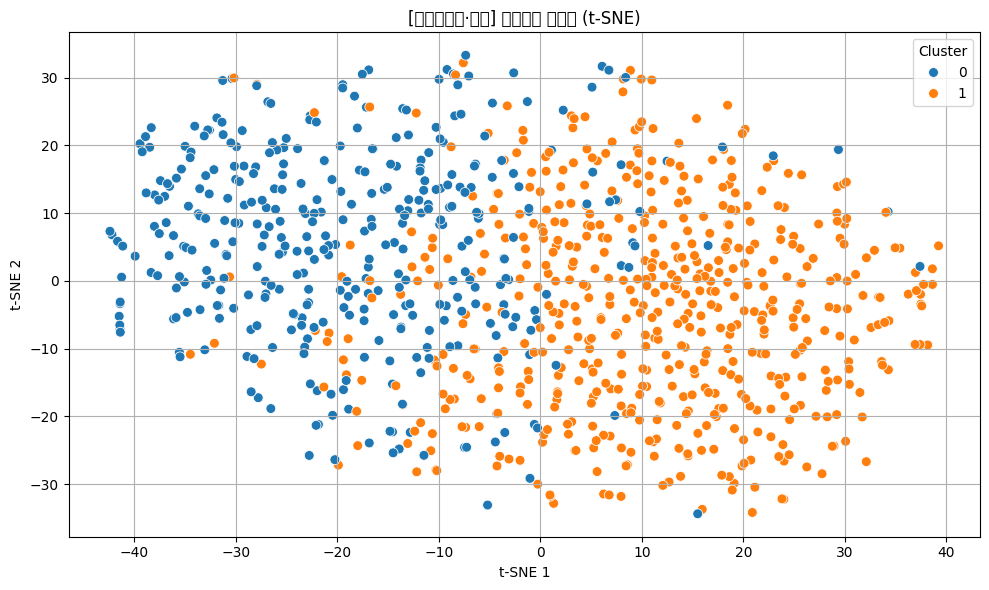

In [34]:
visualize_clusters_tsne(result_df, "회계담당자·기타")

클러스터 별 이직확률 분포

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_resignation_prob_distribution(df, tag_name):
    """
    주어진 tag에 대해 클러스터별 이직확률 분포를 박스플롯으로 시각화합니다.
    """
    df_tag = df[df["tag"] == tag_name].copy()

    if df_tag["cluster"].nunique() <= 1:
        print(f"'{tag_name}'은(는) 클러스터 수가 부족하여 분포 비교 생략됨")
        return

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="cluster", y="이직확률", data=df_tag, palette="Set2")
    plt.title(f"[{tag_name}] 클러스터별 이직확률 분포")
    plt.xlabel("Cluster")
    plt.ylabel("이직확률")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-32-5a14fe1bf13c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="이직확률", data=df_tag, palette="Set2")
<ipython-input-32-5a14fe1bf13c>:20: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-5a14fe1bf13c>:20: UserWarning: Glyph 51649 (\N{HANGUL SYLLABLE JIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-5a14fe1bf13c>:20: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-5a14fe1bf13c>:20: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-32-5a14fe1bf13c>:20: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyt

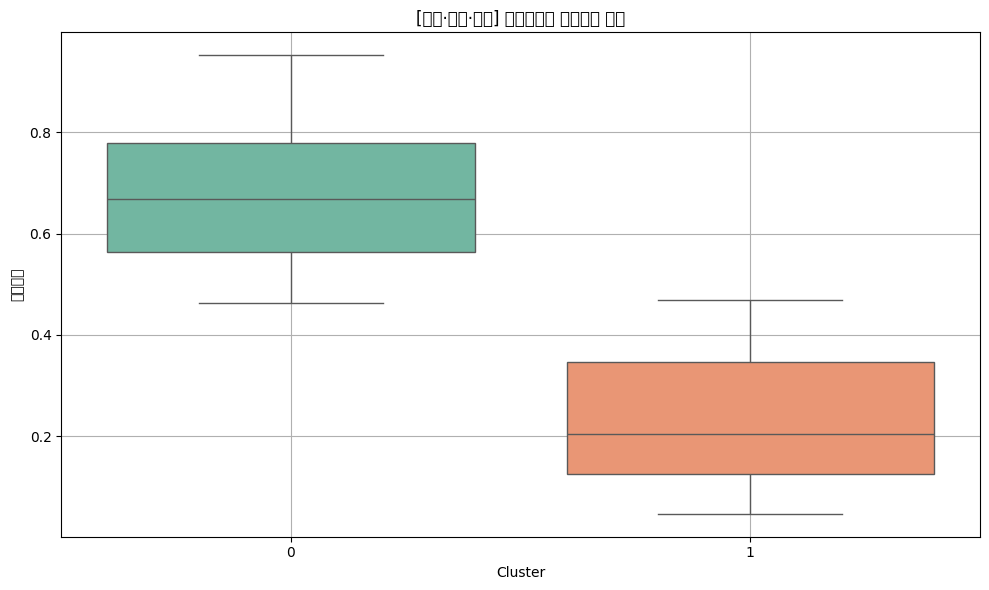

In [35]:
plot_resignation_prob_distribution(result_df, "회계·세무·법무")